<a href="https://colab.research.google.com/github/charliesire/FunQuant/blob/main/short_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#remotes::install_github(\"CharlieSire/FunQuant\") # when repo will becom public
remotes::install_local("FunQuant-main.zip") # once uploaded in colab path
#install.packages(\"remotes\") # when released on CRAN

install.packages("randtoolbox")
install.packages("evd")
install.packages("ggplot2")
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(FunQuant)

library(randtoolbox)
library(ggplot2)
library(evd)
library(gridExtra)

The main asset of the package is to perform probabilistic quantization of random outputs of any dimension. 

We define the spatial function we investigate here, taking as inputs a vector in $\mathbb{R}^2$, and returning a map 20x20.

In [7]:
func2D <- function(X){
  Zgrid <- expand.grid(z1 = seq(-5,5,l=20),z2 = seq(-5,5,l=20))
  n<-nrow(X)
  Y <- lapply(1:n, function(i){(X[i,2] > -0.1)*X[i,2]*X[i,1]*exp(-((0.8*Zgrid$z1+0.2*Zgrid$z2-10*X[i,1])**2)/(60*X[i,1]**2))*(Zgrid$z1-Zgrid$z2)*cos(X[i,1]*4)^2*sin(X[i,2]*4)^2})
  Ymaps<- array(unlist(Y),dim=c(20,20,n))
  return(abs(Ymaps))
}

We create a function to plot the spatial outputs

In [8]:
plot_map = function(map, max = NULL, min = NULL){
  gamma_toplot = expand.grid(seq(-5,5,l=20),seq(-5,5,l=20))
  gamma_toplot$f = as.numeric(map)
  if(is.null(max))
  {p = ggplot(gamma_toplot) + geom_raster(aes(x = Var1, y = Var2, fill = f)) + scale_fill_continuous(type = "viridis",direction = -1, name = "h") + theme_bw()}
  else{p = ggplot(gamma_toplot) + geom_raster(aes(x = Var1, y = Var2, fill = f)) + scale_fill_continuous(type = "viridis", direction = -1, limits = c(min, max), name = "h") + theme_bw()  + theme(legend.text = element_text(size=13),legend.title = element_text(size=13))}
  return(p)
}

We can introduce the design of experiments

In [11]:
design = as.data.frame(halton(400,2))*2-1
outputs = func2D(design)

We can first perform quantization without considering the probabilistic distribution of the inputs. This is classical K-means quantization.

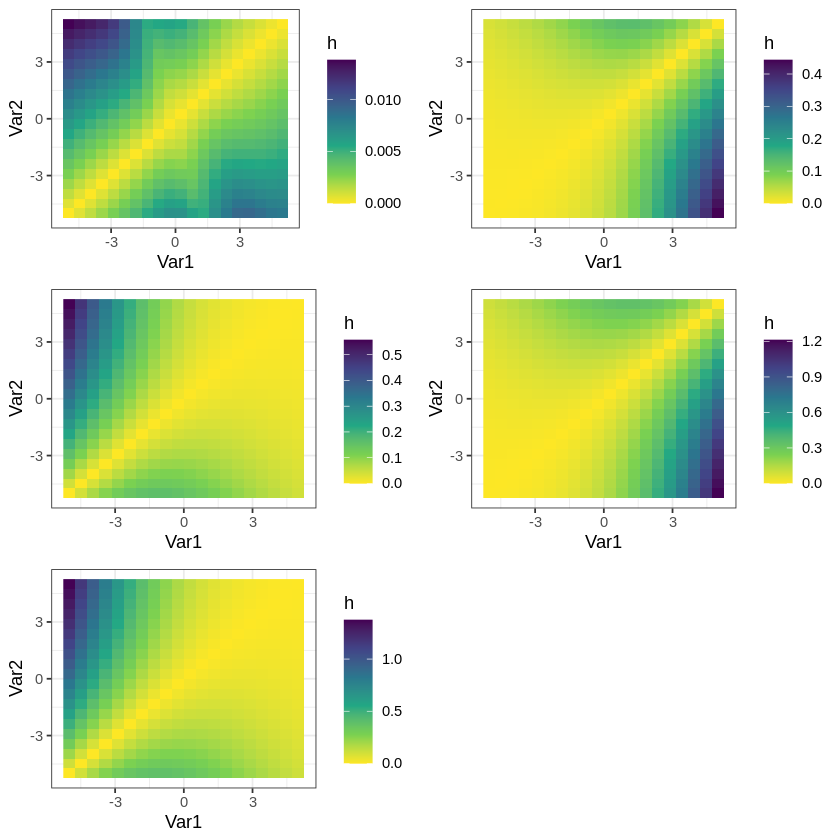

In [12]:
sum_depth = Vectorize(function(i){sum(outputs[,,i])})(1:dim(outputs)[3])
gamma = lapply(1:5, function(i){outputs[,,which.min(abs(as.numeric(quantile(sum_depth,c(0,0.6,0.7,0.8,0.9))[i]) - sum_depth))[1]]}) #gamma will be the starting set of prototypes of the quantization. We choose an maps of only 0, and the maps with increasing sum of pixels

res_proto_1 = proto_map_algo(gamma = gamma, outputs = outputs) 

list_plots_1 = list()
for(i in 1:length(res_proto_1$gamma)){
  list_plots_1[[i]] = plot_map(res_proto_1$gamma[[i]])
}
do.call("grid.arrange", c(list_plots_1, ncol=2))


We can also consider the probabilistic distribution of the inputs.

In [13]:
f2 = function(x){
  res = 0
  ptrunc = pgev(-1, loc=-0.4,scale=0.1) + 1 - pgev(1, loc=-0.4,scale=0.1)
  if(x>=-1 & x < 1){res = dgev(x, loc=-0.4,scale=0.1)/(1-ptrunc)}
  return(res)
}
f1 = function(x){
  if(x > -1 & x < 1){return(1/2)}
  else{return(0)}
}
fX = function(x){f1(x[1])*f2(x[2])}

The design of experiments is a sobol sequence that can be considered as a uniform distribution, which is often the case.

In [14]:
g = function(x){
  if(sum(x > -1) == length(x) & sum(x < 1) == length(x)){return(1/4)}
  else{return(0)}
}

Then we can perform a probabilistic quantization

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


[1] 0.9940990479 0.0004403711 0.0009043848 0.0003359461 0.0003420901


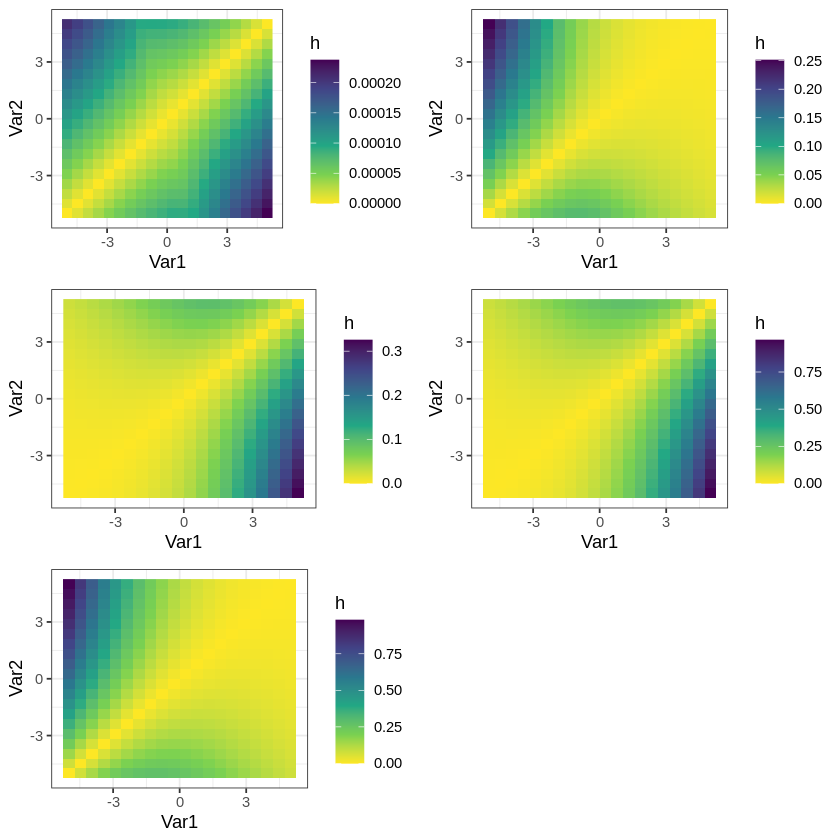

In [15]:
density_ratio = compute_density_ratio(f = fX, g = g, inputs = design)
res_proto_2 = proto_map_algo(gamma = gamma, outputs = outputs, density_ratio = density_ratio) 

list_plots_2 = list()
for(i in 1:length(res_proto_2$gamma)){
  list_plots_2[[i]] = plot_map(res_proto_2$gamma[[i]])
}
do.call("grid.arrange", c(list_plots_2, ncol=2))

print(res_proto_2$probas)

In order to reduce the variance of the estimators, it would be interesting the increase the size of the outputs sample. A metamodel could be introduce. The vignette "long_example" tackles this issue.